## Train DML Models for CDS Index Pricing 

In [131]:
# Library requirements 
import pandas as pd
import numpy as np 
import time 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

%run dml_models.ipynb
%run plotting.ipynb


## Config Settings  

Configuration settings for Model, Data and Control;   

-   **Model**:   Controlling which model to train with (or load a saved model)  
-   **Data**:    Specify the training features and gradients to use and the target label  
-   **Control**: Specify how to normalise the data, how many training epochs, if subsampling and what metric to use. 


In [31]:
# Saved Models 

# model_dml_(20_20_20_20_1_KIG_E8000_1e5_SP)_(s_t)_norm_(index_contracts_sublonger_all)


config = dict(# Model
              model = 'model_dml',      # model version 
              train_or_load = 'load',   # (train, load) 
              model_path ='./saved_dml_models/', 
              model_save_name = '',     # train_or_load == 'train'
              model_load_name = 'model_dml_(20_20_20_20_1_KIG_E8000_1e5_SP)_(s_t)_norm_(index_contracts_sublonger_all)', # train_or_load == 'load'

              # Data 
              data_path = "./../../data/", 
              data_name = "index_priced_fd.csv",    # (index_priced_fd.csv) fd for first derivatives  
              X = ('spread', 'mat_duration'),       # features to train on 
              y = ('mtm',),                         # y label 
              dydx = ('cs01', 'theta'),             # gradients to train on 

              # Control Parameters 
              epochs = 1000,
              apply_sampling = True,
              apply_rounding = True,
              loss = 'mean_squared_error'      # (mean_absolute_error, mean_squared_error)
)


## Load and Sample Data  

Load the training data and filter for only what we need for model training. 

In [32]:
# Read the CDS Index contracts 
data_orig = pd.read_csv(config['data_path'] + config['data_name'])
data_orig = data_orig[(data_orig.recovery == 0.4) & (data_orig.coupon == 100)] 
data = data_orig[list(config['X'] + config['dydx'] + config['y'])]

if config['apply_sampling']:
    # add any subsampling required here ...  
    # ignore contracts which are almost worthless 
    sampled_data = data[data.mtm.abs() > 1e-5].copy()
else:
    sampled_data = data.copy() 

if (config['apply_rounding']):    
    sampled_data.loc[:,['mtm', 'spread', 'cs01', 'theta']] = sampled_data.loc[:,['mtm', 'spread', 'cs01', 'theta']].round(8)  

sampled_data


,spread,mat_duration,cs01,theta,mtm
190,0.000539,10.202778,9.400222,-0.006896,-0.082659
191,0.001046,10.202778,9.325650,-0.006471,-0.077909
192,0.001586,10.202778,9.246984,-0.006027,-0.072896
193,0.002053,10.202778,9.179495,-0.005649,-0.068594
194,0.002554,10.202778,9.107601,-0.005250,-0.064011
...,...,...,...,...,...
236055,0.033058,0.013889,0.013826,0.022913,0.000318
236056,0.033561,0.013889,0.013826,0.023413,0.000325
236057,0.034053,0.013889,0.013826,0.023902,0.000332
236058,0.034572,0.013889,0.013825,0.024419,0.000339


## Preprocess Data  

Separate the data into input features (X), input gradients (dydx) and target label (y).  
Create a train:test split.  
Define function for preprocessing the data (normalisation and creation of custom gradient loss function).  
Define function for reversing the normlisation.  

In [33]:
X = sampled_data[list(config['X'])]
y = sampled_data[list(config['y'])].values.reshape(-1, 1)
dydx = sampled_data[list(config['dydx'])]

# Split into training and testing sets
X_train, X_true, y_train, y_true, dydx_train, dydx_true = train_test_split(X, y, dydx, test_size=0.2, random_state=42)

## Build, Compile and Fit the Model (or load saved model) 

In [34]:
if config['train_or_load'] == 'train':
    tf.keras.backend.clear_session()

    # Constants 
    differential_weight = 2
    STEPS_PER_EPOCH = 16
    BATCH_SIZE = 1024
    EPOCHS = 8000   # config override 

    # Create a time decaying learning rate schedule 
    lr_inv_time_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.01,
        decay_steps=STEPS_PER_EPOCH*100,
        decay_rate=50,
        staircase=False)

    # Preprocess data and build the model
    prep_layer, grad_loss = preprocess_data(X_train.values, y_train, dydx_train.values, prep_type='Normalisation')
    model = build_and_compile_model(prep_layer.output_n(),
                                    config['model'], 
                                    grad_loss, 
                                    differential_weight,
                                    lr_schedule=lr_inv_time_decay  # lr_inv_time_decay 
                                    )

    # Train the model
    start_time = time.time()
    history = train_model(model,
                            prep_layer,
                            X_train.values, 
                            y_train, 
                            dydx_train.values, 
                            epochs=EPOCHS,
                            batch_size = BATCH_SIZE,
                            x_true=X_true.values, 
                            y_true=y_true, 
                            dydx_true=dydx_true.values
                            )
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    model.save(config['model_path'] + config['model_save_name'])

elif config['train_or_load'] == 'load':
    prep_layer, grad_loss = preprocess_data(X_train.values, y_train, dydx_train.values, prep_type='Normalisation')
    model = load_model(config['model_path'] + config['model_load_name'], custom_objects={'grad_custom_loss': grad_loss})

else:
    raise ValueError(f"Unrecognized value for 'train_or_load': {config['train_or_load']}. Expected 'train' or 'load'.")




## Evaluate the Model  

Evaluate the model on the test set and create dataframes useful for analysing the distribution and size of relative and absolute accuracy of ground truth vs predicted MtMs, CS01s and Thetas.   

230/230 [==============================] - 0s 1ms/step
Mean Squared Error on mtm test set: 1.557890732358171e-09
Mean Squared Error on cs01 test set: 0.0005269684883452498
Mean Squared Error on theta test set: 3.956941637704688e-09


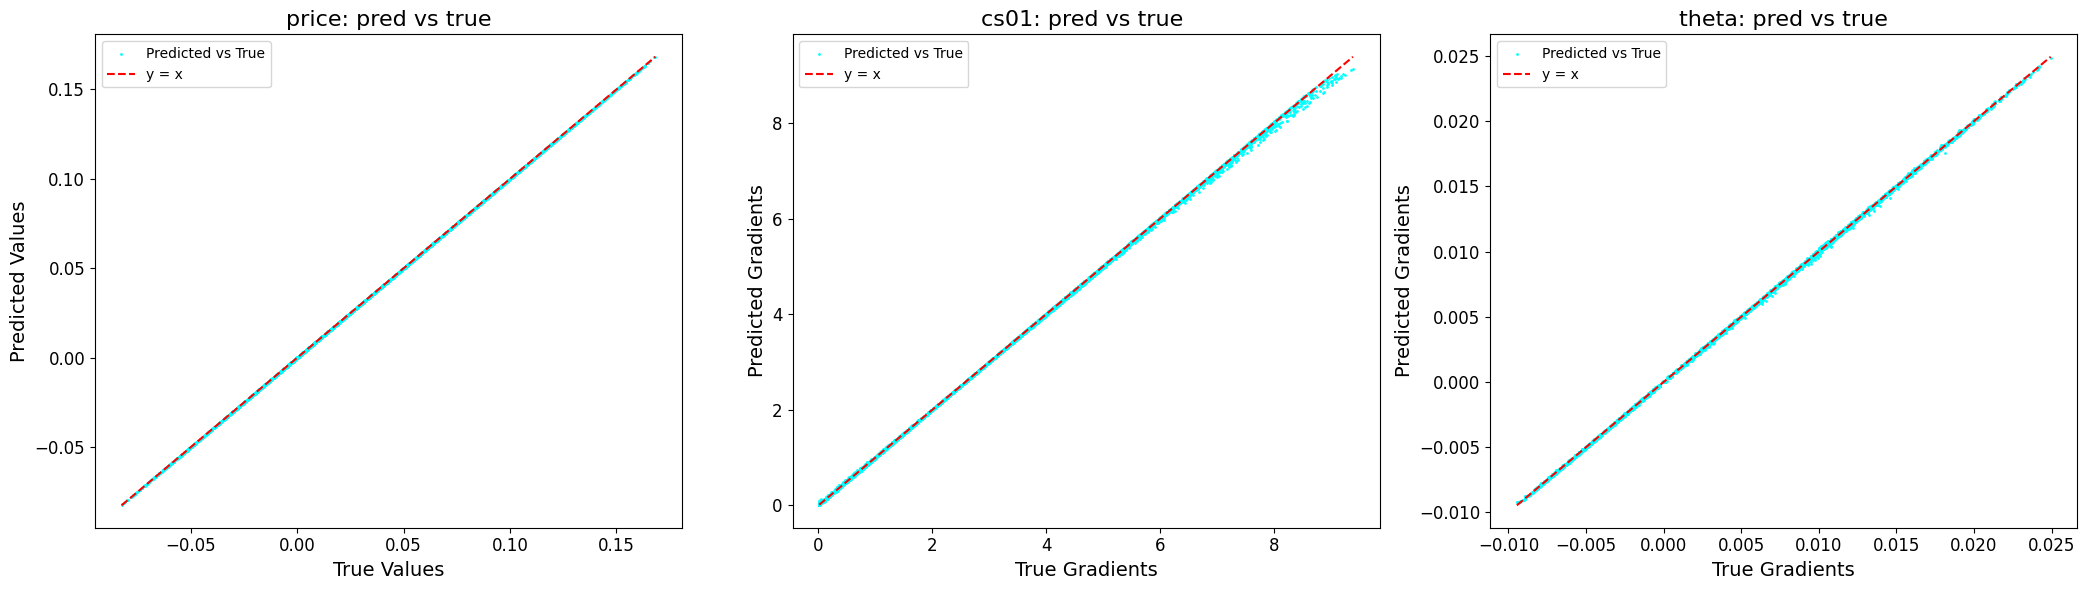

,y_true,y_pred,diff_rel,diff_abs
0,0.048805,0.048771,0.068604,0.000033
1,0.031498,0.031471,0.083116,0.000026
2,0.022356,0.022364,-0.036094,-0.000008
3,0.121132,0.121034,0.080888,0.000098
4,-0.001444,-0.001410,2.359773,-0.000034
...,...,...,...,...
7342,0.019526,0.019530,-0.024743,-0.000005
7343,0.001145,0.001132,1.149853,0.000013
7344,0.029323,0.029314,0.029376,0.000009
7345,0.034559,0.034562,-0.008207,-0.000003


In [132]:
# Predict and store results
y_pred, dydx_pred = predict_unscaled(model, prep_layer, X_true.values)
pred_values = y_pred
pred_deltas = dydx_pred

mse_y = mean_squared_error(y_true, y_pred)
mse_cs01 = mean_squared_error(dydx_true.iloc[:, 0], dydx_pred[:, 0])
mse_theta = mean_squared_error(dydx_true.iloc[:, 1], dydx_pred[:, 1])
print(f'Mean Squared Error on mtm test set: {mse_y}')
print(f'Mean Squared Error on cs01 test set: {mse_cs01}')
print(f'Mean Squared Error on theta test set: {mse_theta}')

# Utility to prepare data frames of true and predicted values of the model 
def prepare_results(true, pred, true_name, pred_name, flatten=True):
    if flatten:
        true = true.flatten()
        pred = pred.flatten()

    df = pd.DataFrame({
        true_name: true,
        pred_name: pred
    })
    df['diff_rel'] = (df[true_name] - df[pred_name]) / df[true_name] * 100
    df['diff_abs'] = (df[true_name] - df[pred_name]) 

    return df

df_mtm = prepare_results(y_true, y_pred, 'y_true', 'y_pred')
df_cs01 = prepare_results(dydx_true.iloc[:, 0], dydx_pred[:, 0], 'cs01_true', 'cs01_pred', flatten=False)
df_theta = prepare_results(dydx_true.iloc[:, 1], dydx_pred[:, 1], 'theta_true', 'theta_pred', flatten=False)

plot_index_dml_fit(y_true, y_pred, dydx_true, dydx_pred, 'price', 'cs01', 'theta')

df_mtm

## Prediction Errors  

Amanlyse the prediction relative and absolute prediction accuracy across MtM bins and uniformly across the entire test set for MtM and gradients CS01, Theta. 

### MtM

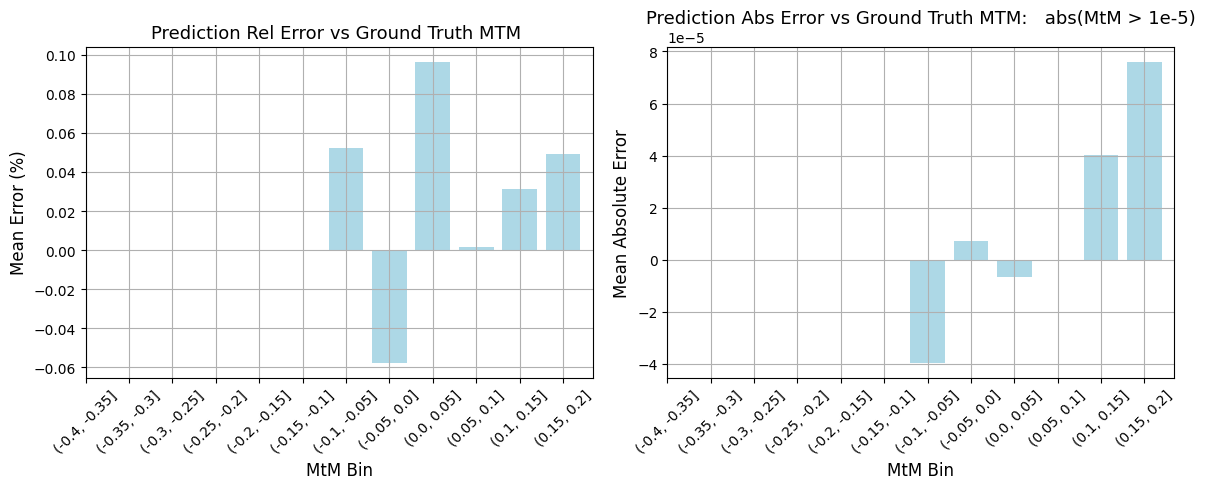

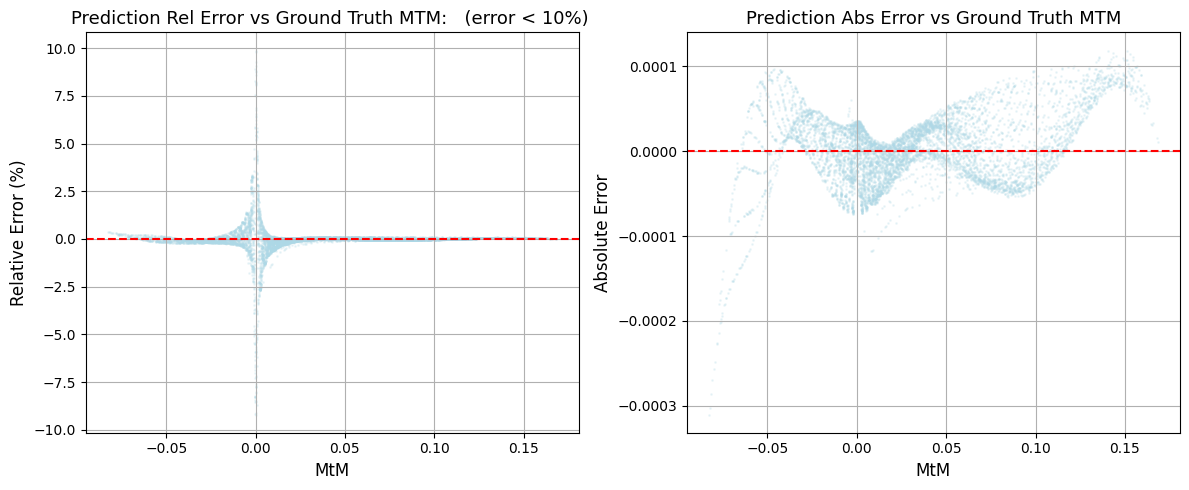

,mtm_bin,diff_rel
0,"(-0.4, -0.35]",NaN
1,"(-0.35, -0.3]",NaN
2,"(-0.3, -0.25]",NaN
3,"(-0.25, -0.2]",NaN
4,"(-0.2, -0.15]",NaN
5,"(-0.15, -0.1]",NaN
6,"(-0.1, -0.05]",0.052140
7,"(-0.05, 0.0]",-0.057520
8,"(0.0, 0.05]",0.096480
9,"(0.05, 0.1]",0.001681


In [36]:
# Mean percentage prediction error across MtM bins 
df_mtm['y_test'] = df_mtm['y_true']
bin_errors = plot_pred_error_rel_twice(df_mtm, df_mtm, 'idx', 'Prediction Rel Error vs Ground Truth MTM ', 'Prediction Abs Error vs Ground Truth MTM:   abs(MtM > 1e-5)')

# Relative and absolute prediction errors (no bins) 
df = df_mtm[abs(df_mtm['diff_rel']) < 10]
plot_pred_error_twice(df , df, 'idx_cs01', 'Prediction Rel Error vs Ground Truth MTM:   (error < 10%) ', 'Prediction Abs Error vs Ground Truth MTM', size=1)
bin_errors[0]

### CS01

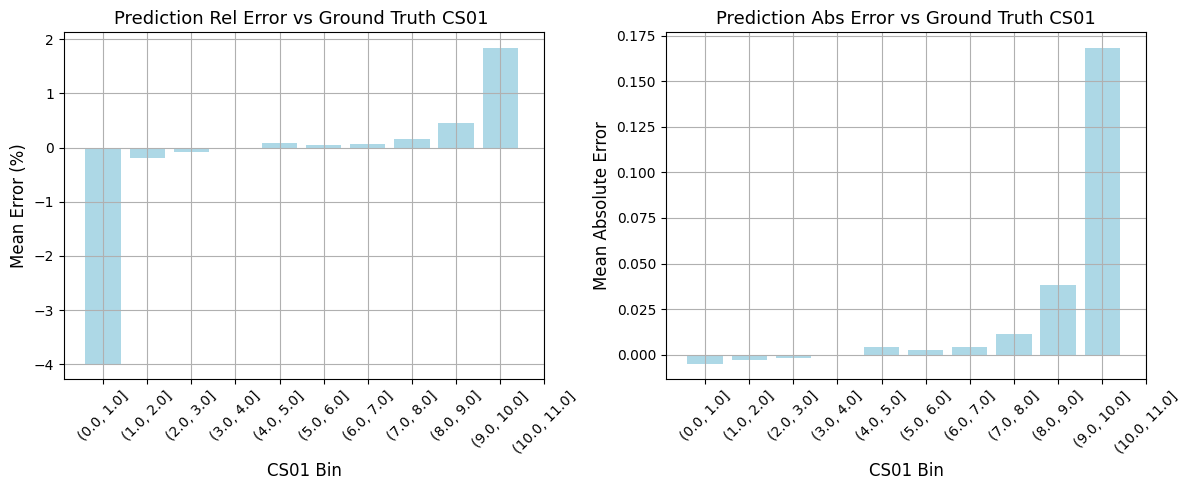

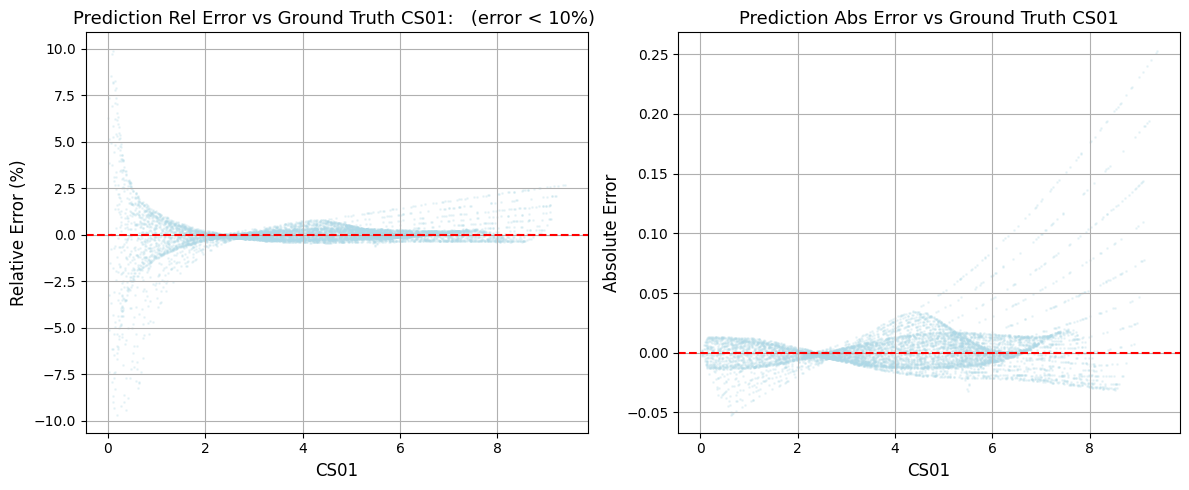

,mtm_bin,diff_rel
0,"(0.0, 1.0]",-3.986922
1,"(1.0, 2.0]",-0.188318
2,"(2.0, 3.0]",-0.082281
3,"(3.0, 4.0]",-0.009057
4,"(4.0, 5.0]",0.090524
5,"(5.0, 6.0]",0.047806
6,"(6.0, 7.0]",0.061321
7,"(7.0, 8.0]",0.151622
8,"(8.0, 9.0]",0.448502
9,"(9.0, 10.0]",1.838430


In [37]:
# Mean percentage prediction error across MtM bins 
df_cs01['y_test'] = df_cs01['cs01_true']
bin_errors = plot_pred_error_rel_twice(df_cs01, df_cs01, 'idx_cs01', 'Prediction Rel Error vs Ground Truth CS01 ', 'Prediction Abs Error vs Ground Truth CS01', x='CS01 Bin')

# Relative and absolute prediction errors (no bins) 
df = df_cs01[abs(df_cs01['diff_rel']) < 10]
plot_pred_error_twice(df, df, 'idx_cs01', 'Prediction Rel Error vs Ground Truth CS01:   (error < 10%) ', 'Prediction Abs Error vs Ground Truth CS01', size = 1, x='CS01')
bin_errors[0]

### Theta 

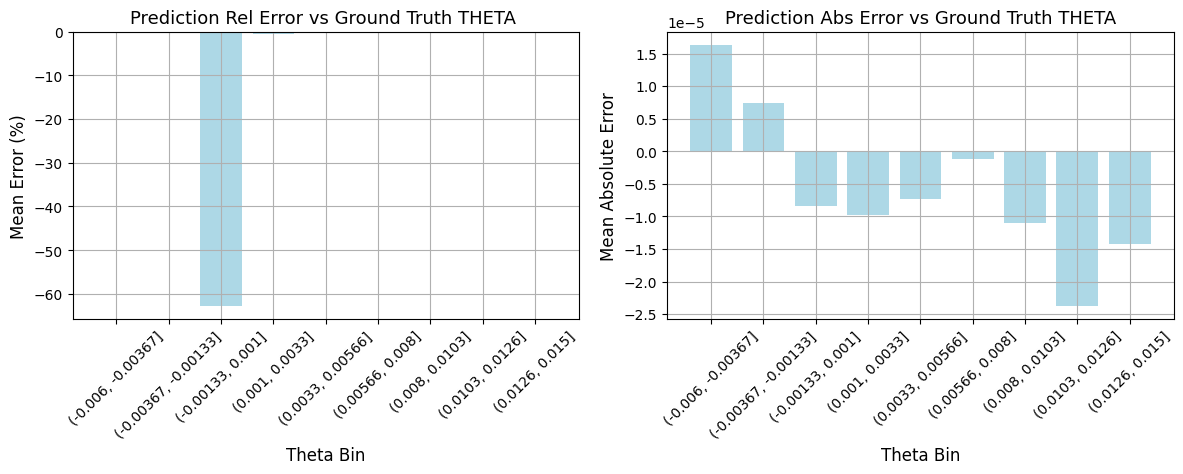

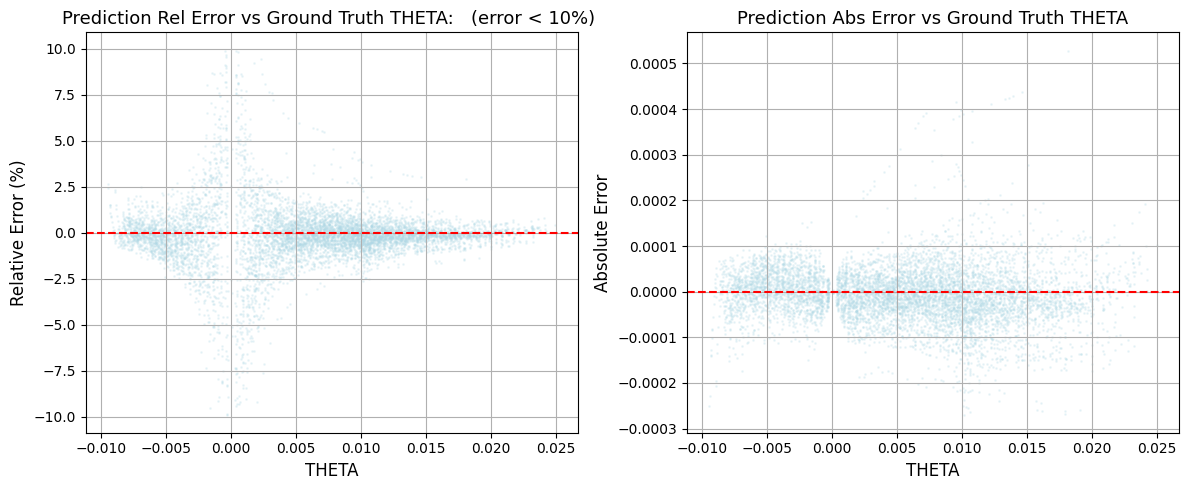

,mtm_bin,diff_rel
0,"(-0.006, -0.00367]",-0.348285
1,"(-0.00367, -0.00133]",-0.297445
2,"(-0.00133, 0.001]",-62.663305
3,"(0.001, 0.0033]",-0.479694
4,"(0.0033, 0.00566]",-0.167337
5,"(0.00566, 0.008]",-0.015939
6,"(0.008, 0.0103]",-0.116060
7,"(0.0103, 0.0126]",-0.214343
8,"(0.0126, 0.015]",-0.104582


In [38]:
# Mean percentage prediction error across MtM bins 
df_theta['y_test'] = df_theta['theta_true']
bin_errors = plot_pred_error_rel_twice(df_theta, df_theta, 'idx_theta', 'Prediction Rel Error vs Ground Truth THETA ', 'Prediction Abs Error vs Ground Truth THETA', x='Theta Bin')

# Relative and absolute prediction errors (no bins) 
df = df_theta[abs(df_theta['diff_rel']) < 10]
plot_pred_error_twice(df, df, 'idx_theta', 'Prediction Rel Error vs Ground Truth THETA:   (error < 10%) ', 'Prediction Abs Error vs Ground Truth THETA', size = 1, x='THETA')
bin_errors[0]

## Reconstruct Data Ready For Error Bar Processing  

In the following, we reconstruct the original training and test data columns ready for analysing the potential for using **First Order Gradient** empirical error bars (FOG Bars )  
Then, the training set is evaluated to give us prediction accuracy for the gradient predictions on the training points.  
From this information we can then use a nearest neigbour algorithm to join the test data rows to the 'nearest' training data rows.  
This in turn allows us to compareobserve whether the NN model predictions for unseen data samples lie within $FOG^+$ error bar estimates.  
Where  $FOG^+$ are the ground truth first order gradients measured at the training points $\pm$ the NN prediction error of gradients on those points.  

In [39]:

def reconstruct_data(X_train, X_true, y_true, dydx_true, y_pred, dydx_pred, data):
    """
    Reconstructs training and test data with original columns, including predictions.

    Parameters:
    -----------
    X_train : DataFrame: training input features.
    X_true : DataFrame: test input features.
    y_true : array: true target values for the test set.
    dydx_true : DataFrame: true gradients for the test set.
    y_pred : array: predicted target values for the test set.
    dydx_pred : array: predicted gradients for the test set.
    data : DataFrame: original data containing all columns.

    Returns:
    --------
    train_data : DataFrame: reconstructed training data with all original columns.
    true_data : DataFrame: reconstructed test data with all original columns, including columns for predicted values and gradients.

    """
    
    # Ensure y arrays are converted to Series with the same index as the corresponding X data
    y_true_series = pd.Series(y_true.flatten(), index=X_true.index)
    y_pred_series = pd.Series(y_pred.flatten(), index=X_true.index)
    # Convert dydx_pred to a DataFrame with the same columns as dydx_true
    dydx_pred_df = pd.DataFrame(dydx_pred, index=X_true.index, columns=dydx_true.columns)

    # TRAIN: Reconstruct the training data with all columns originally present in data_orig
    train_indices = X_train.index
    train_data = data.loc[train_indices].copy()
    
    # TRUE: Reconstruct the true and predicted data with extra original columns from data_orig
    true_indices = X_true.index
    true_data = data.loc[true_indices].copy()
    true_data['mtm_pred'] = y_pred_series
    for col in dydx_pred_df.columns:
        true_data[col + '_pred'] = dydx_pred_df[col]

    return train_data, true_data


train_data, true_data = reconstruct_data(X_train, X_true, y_true, dydx_true, y_pred, dydx_pred, data_orig)


In [40]:
# Evaluate the training data in order to get training gradient uncertainty at the training space points 
y_train_pred, dydx_train_pred = predict_unscaled(model, prep_layer, X_train.values)
y_train_pred_series = pd.Series(y_train_pred.flatten(), index=X_train.index)
train_data['mtm_pred'] = y_train_pred

# Merge with train_data 
dydx_train_pred_df = pd.DataFrame(dydx_train_pred, index=X_train.index, columns=dydx_train.columns)
for col in dydx_train_pred_df.columns:
    train_data[col + '_pred'] = dydx_train_pred_df[col]


919/919 [==============================] - 1s 1ms/step


### Data Sanity Check Visualisation

In [15]:
train_data

,val_date,contractId,currency,coupon,recovery,maturity,indexFactor,flat_ir,spread,smc,mat_duration,mtm,cs01,theta,mtm_pred,cs01_pred,theta_pred
164947,2031-06-05,CDS_219898,EUR,100,0.4,2034-06-20,1,0.03,0.029064,0.019064,3.086111,0.052105,2.605136,0.014893,0.052115,2.609388,0.014954
148268,2030-09-19,CDS_197669,EUR,100,0.4,2034-06-20,1,0.03,0.014526,0.004526,3.805556,0.015520,3.381692,0.003951,0.015522,3.373702,0.003688
119022,2029-06-21,CDS_158673,EUR,100,0.4,2034-06-20,1,0.03,0.016571,0.006571,5.069444,0.028817,4.269926,0.004980,0.028803,4.257572,0.004902
41169,2026-02-26,CDS_54870,EUR,100,0.4,2034-06-20,1,0.03,0.015079,0.005079,8.433333,0.034194,6.511816,0.003129,0.034168,6.499921,0.003180
200957,2032-12-16,CDS_267908,EUR,100,0.4,2034-06-20,1,0.03,0.034053,0.024053,1.530556,0.034361,1.385967,0.020958,0.034388,1.408530,0.020998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108240,2029-01-04,CDS_144291,EUR,100,0.4,2034-06-20,1,0.03,0.025557,0.015557,5.536111,0.070761,4.245129,0.010450,0.070783,4.257191,0.010419
40275,2026-02-12,CDS_53676,EUR,100,0.4,2034-06-20,1,0.03,0.018067,0.008067,8.472222,0.053461,6.283504,0.004807,0.053416,6.282634,0.004839
72654,2027-07-01,CDS_96855,EUR,100,0.4,2034-06-20,1,0.03,0.007539,-0.002461,7.072222,-0.014999,6.177351,-0.001767,-0.014960,6.194575,-0.001848
5610,2024-08-22,CDS_7461,EUR,100,0.4,2034-06-20,1,0.03,0.010528,0.000528,9.969444,0.004179,7.896023,0.000296,0.004224,7.895847,0.000393


In [108]:
true_data

,val_date,contractId,currency,coupon,recovery,maturity,indexFactor,flat_ir,spread,smc,mat_duration,mtm,cs01,theta,mtm_pred,cs01_pred,theta_pred
61875,2027-01-14,CDS_82476,EUR,100,0.4,2034-06-20,1,0.03,0.018067,0.008067,7.538889,0.048805,5.768065,0.005149,0.048771,5.766727,0.005118
150528,2030-10-24,CDS_200679,EUR,100,0.4,2034-06-20,1,0.03,0.019545,0.009545,3.708333,0.031498,3.207126,0.007553,0.031471,3.204898,0.007541
183380,2032-03-18,CDS_244481,EUR,100,0.4,2034-06-20,1,0.03,0.020536,0.010536,2.288889,0.022356,2.080498,0.008875,0.022364,2.081766,0.009037
1593,2024-06-20,CDS_2094,EUR,100,0.4,2034-06-20,1,0.03,0.027082,0.017082,10.144444,0.121132,6.198717,0.008056,0.121034,6.198330,0.007933
230148,2034-03-16,CDS_306849,EUR,100,0.4,2034-06-20,1,0.03,0.004536,-0.005464,0.266667,-0.001444,0.264647,-0.005441,-0.001410,0.263204,-0.005383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179326,2032-01-15,CDS_239077,EUR,100,0.4,2034-06-20,1,0.03,0.018564,0.008564,2.463889,0.019526,2.241595,0.007384,0.019530,2.243599,0.007326
229717,2034-03-09,CDS_306268,EUR,100,0.4,2034-06-20,1,0.03,0.014055,0.004055,0.286111,0.001145,0.282537,0.003905,0.001132,0.291762,0.003980
171682,2031-09-18,CDS_228883,EUR,100,0.4,2034-06-20,1,0.03,0.021523,0.011523,2.794444,0.029323,2.478797,0.009360,0.029314,2.479398,0.009534
193299,2032-08-19,CDS_257700,EUR,100,0.4,2034-06-20,1,0.03,0.030056,0.020056,1.861111,0.034559,1.671330,0.017167,0.034562,1.670767,0.017242


In [109]:
# Save to CSV file: The data for the chosen best runs is already saved. 

#train_data.to_csv('py_train_data.csv', index=False)
#true_data.to_csv('py_true_data.csv', index=False)


## Process the FOG Error Bars  

Calculate the $FOG^+$ error bars and plot how many MtM values fall within these error bar estimates.  

     val_date  contractId currency  coupon  recovery    maturity  indexFactor  \
1  2030-10-24  CDS_200680      EUR     100       0.4  2034-06-20            1   
2  2032-03-18  CDS_244480      EUR     100       0.4  2034-06-20            1   
3  2024-06-20    CDS_2095      EUR     100       0.4  2034-06-20            1   
4  2034-03-16  CDS_306850      EUR     100       0.4  2034-06-20            1   

   flat_ir    spread       smc  ...  gt_nn_error  gt_fo_error  nn_fo_error  \
1     0.03  0.020043  0.010043  ...     0.083124     0.007535     0.090735   
2     0.03  0.020043  0.010043  ...    -0.036081     0.004221    -0.031849   
3     0.03  0.027546  0.017546  ...     0.080886     0.008433     0.089391   
4     0.03  0.005041 -0.004959  ...     2.359453    -0.001021     2.415423   

   mtm_t_pred_within_nn_error  mtm_t_within_nn_error  \
1                        True                   True   
2                        True                  False   
3                        True      

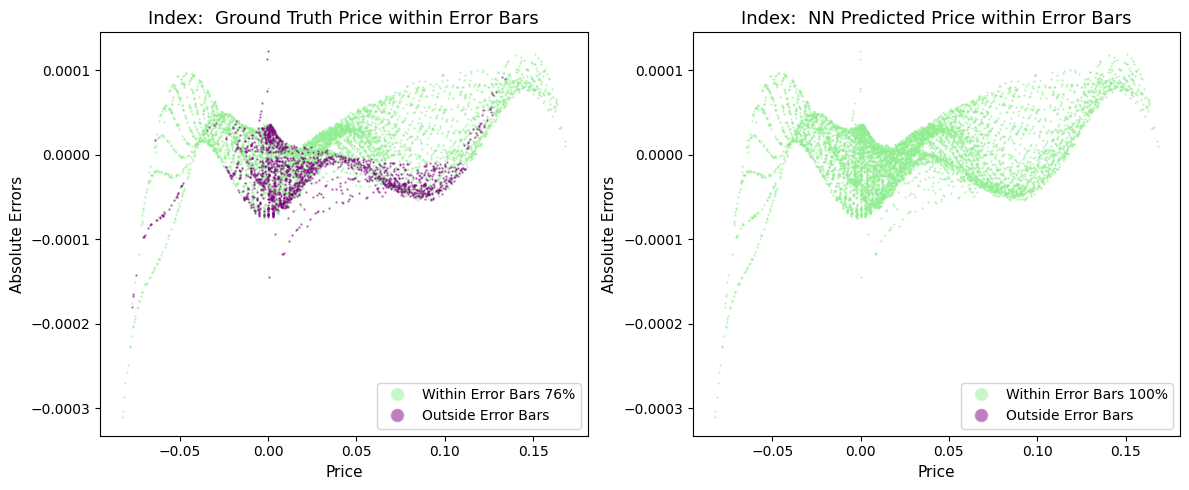

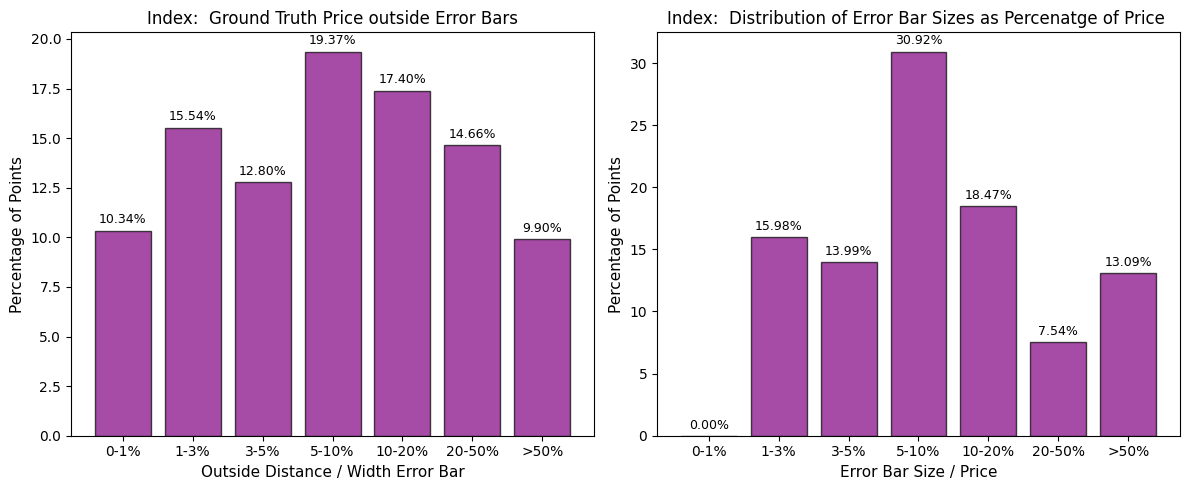

In [133]:

result = error_bars_first_order_estimate(train_data, true_data)
print(result[1:5])
proportion_within_error = result['mtm_t_within_nn_error'].sum() / len(result)
print(f"Proportion of true MtM within error: {proportion_within_error}")

plot_error_bars(result, type='Index: ', within_val_gt='75%', within_val_nn='100%')
plot_true_misses_and_rel_size(result, type='Index: ')